In [1]:
import os
import sys

sys.path.append(os.getcwd() + '/')

In [3]:
from experiments import setup_experiments

exps = setup_experiments("far_bias")

In [4]:
exps.path

'/data/Data/SimBA-MACAW/far_bias'

In [70]:
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np

no_bias_dir = Path('/data/Data/SimBA-MACAW/no_bias/data/images/test')
far_bias_dir = Path(exps.path)/'data'/'images'/'test'
far_bias_csv = Path(exps.path)/'data'/'csv'/'test.csv'
macaw_cf_dir = Path(exps.path)/'cfs'/'no_bias'

df = pd.read_csv(far_bias_csv, low_memory=True)
bias_labels = df['bias_label'].to_numpy()
file_names = df['filename'].tolist()

bias_file_names = [f.replace('nii.gz','tiff') for f,b in zip(file_names,bias_labels) if b]
n= len(bias_file_names)

In [76]:
import numpy as np
from tifffile import tifffile as tiff
 
def three_images(idx): 
    no_bias_img = tiff.imread(os.path.join(no_bias_dir, bias_file_names[idx])).squeeze()
    far_bias_img = tiff.imread(os.path.join(far_bias_dir, bias_file_names[idx])).squeeze()
    macaw_cf_img = tiff.imread(os.path.join(macaw_cf_dir, bias_file_names[idx])).squeeze()
    return no_bias_img, far_bias_img, macaw_cf_img

Text(0.5, 1.0, 'CF - Far')

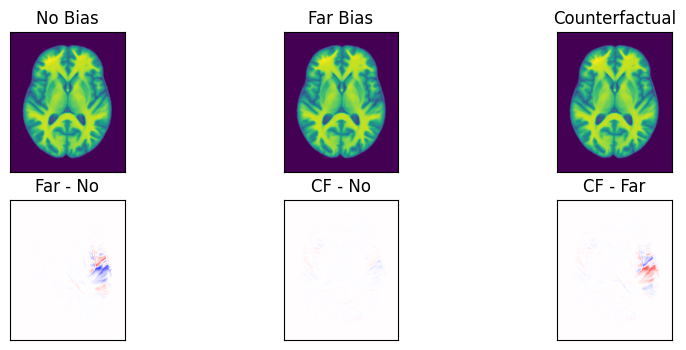

In [77]:
no_bias_img, far_bias_img, macaw_cf_img = three_images(np.random.randint(0,n,1).squeeze())

fig, axs = plt.subplots(2, 3, figsize=(10, 4))
[a.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]) for ax in axs for a in ax]

axs[0, 0].imshow(no_bias_img)
axs[0, 0].set_title("No Bias")

axs[0, 1].imshow(far_bias_img)
axs[0, 1].set_title("Far Bias")

axs[0, 2].imshow(macaw_cf_img)
axs[0, 2].set_title("Counterfactual")

axs[1, 0].imshow(far_bias_img - no_bias_img, cmap ='seismic', clim=(-1, 1))
axs[1, 0].set_title("Far - No")

axs[1, 1].imshow(macaw_cf_img - no_bias_img, cmap ='seismic', clim=(-1, 1))
axs[1, 1].set_title("CF - No")

axs[1, 2].imshow(macaw_cf_img - far_bias_img, cmap ='seismic', clim=(-1, 1))
axs[1, 2].set_title("CF - Far")

In [118]:
def TEA(no_bias_img, far_bias_img, cf_img):
    no_far = (no_bias_img - far_bias_img).flatten()
    cf_far = (cf_img - far_bias_img).flatten()
    
    no_far_mag = np.linalg.norm(no_far)
    cf_far_mag = np.linalg.norm(cf_far)
    projection = no_far.dot(cf_far)/no_far_mag
    
    bias_removed = projection/no_far_mag
    bias_amplified = np.sqrt(cf_far_mag**2 - projection**2)
    
    return bias_removed, bias_amplified

In [124]:
tea = []
for i in range(n):
    tea.append(TEA(*three_images(i)))    
tea = np.array(tea)

Text(0, 0.5, 'Bias amplified')

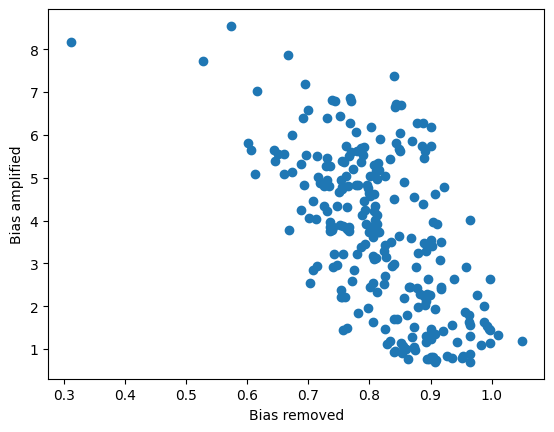

In [126]:
import matplotlib.pyplot as plt

plt.scatter(tea[:,0], tea[:,1])
plt.xlabel('Bias removed')
plt.ylabel('Bias amplified')